In [65]:
import model
import importlib
import utils
import processors
import pickle
import os
from sklearn.model_selection import ParameterGrid
import numpy as np
import matplotlib.pyplot as plt

In [66]:
importlib.reload(model);
importlib.reload(processors)
importlib.reload(utils);

In [67]:
SAVE = False

In [68]:
if SAVE and os.path.exists("dataloader.pkl"):
    with open('dataloader.pkl', 'rb') as f:
        dataloader = pickle.load(f)
else:
    dataloader = utils.DataLoader("../data/raw")
    dataloader.load()
    dataloader.cut("Time", "CGM")
    dataloader.process()
    
if SAVE:
    with open('dataloader.pkl', 'wb') as f:
        pickle.dump(dataloader, f)

Found 24 files in ../data/raw
ohio540 Train: (13109, 43) Test: (3066, 43)
ohio544 Train: (12672, 43) Test: (3136, 43)
ohio552 Train: (11098, 43) Test: (3950, 43)
ohio559 Train: (12081, 46) Test: (2877, 46)
ohio563 Train: (13097, 46) Test: (2692, 46)
ohio567 Train: (13536, 43) Test: (2870, 43)
ohio570 Train: (11611, 46) Test: (2879, 46)
ohio575 Train: (13103, 46) Test: (2719, 46)
ohio584 Train: (13247, 43) Test: (2995, 43)
ohio588 Train: (13105, 46) Test: (2881, 46)
ohio591 Train: (12756, 46) Test: (2847, 46)
ohio596 Train: (13630, 43) Test: (3002, 43)


In [69]:
TUNE = False

if TUNE:
    param_grid = {'window_size': list(range(5, 20)), 'std': [0.5, 1.0, 1.5, 2.0]}
    grid = list(ParameterGrid(param_grid))

    best_rmse = float('inf')
    best_params = None
    
    for params in grid:
        m = model.Model("CGM", dataloader, window_size=params['window_size'], std=params['std'])
        m.fit()
        RMSE = []
        skip = 24
        for i in range(len(dataloader['test'])):
            predictions = m.predict(dataloader['test'][i]).values[skip:]
            RMSE.append(np.sqrt(np.mean((dataloader['test'][i]['CGM'].values[skip:] - predictions)**2)))
        mean_rmse = np.mean(RMSE)
        print(f"window_size: {params['window_size']}, std: {params['std']}, RMSE: {mean_rmse}")
        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = params

    print(f"Best parameters: {best_params}, Best RMSE: {best_rmse}")

In [70]:
m = model.Model("CGM", dataloader, window_size=17, std=2)
m.fit()

Fitting with features: ['upper' 'middle' 'lower' 'prev' 'prev%' 'upper%' 'middle%' 'lower%'
 'rolling_mean_2' 'rolling_std_2' 'rolling_mean_3' 'rolling_std_3'
 'rolling_mean_4' 'rolling_std_4' 'rolling_mean_5' 'rolling_std_5'
 'rolling_mean_6' 'rolling_std_6' 'rolling_mean_7' 'rolling_std_7'
 'rolling_mean_8' 'rolling_std_8' 'rolling_mean_9' 'rolling_std_9'
 'rolling_mean_10' 'rolling_std_10' 'rolling_mean_11' 'rolling_std_11']


In [71]:
import pandas as pd
#m.optimize_lgbm_params(pd.concat(dataloader['tune']))

In [72]:
m.fit()
skip = 24
RMSE = []
show = False
for i in range(len(dataloader['test'])):
    predictions = m.predict(dataloader['test'][i]).values[skip:]
    RMSE.append(np.sqrt(np.mean((dataloader['test'][i]['CGM'].values[skip:] - predictions)**2)))
    if show:
        plt.figure(figsize=(10, 6))
        plt.plot(dataloader['test'][i]['CGM'].values[skip:], label='True')
        plt.plot(predictions, label='Predicted')
        plt.legend()
        plt.show()
mean_rmse = np.mean(RMSE)
print(mean_rmse)

4.323914558835572


In [73]:
from sklearn.metrics import root_mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

rmses = []
total = []
forecast_sizes = list(range(3, 37, 3))
show = False

for size in forecast_sizes:
    for i in range(len(dataloader['test'])):
        test = dataloader['test'][i][:25]
        forecasts = m.forecast(test, size + 1)
        truth = dataloader['test'][i]['CGM'][25:25+size]
        if show:
            plt.figure(figsize=(10, 6))
            plt.plot(truth, label='Truth')
            plt.plot(forecasts['prev'][1:], label='Predicted')
            plt.title(root_mean_squared_error(truth, forecasts['prev'][1:]))
            plt.legend()
            plt.show()
        rmse = root_mean_squared_error(truth, forecasts['prev'][1:len(truth) + 1])
        rmses.append(rmse)
    print(f"Forecast of {size * 5} minutes, RMSE: {np.mean(rmses)}")
    total.append(np.mean(rmses))
    rmses = []

Forecast of 15 minutes, RMSE: 6.917870703085053
Forecast of 30 minutes, RMSE: 10.42191638236439
Forecast of 45 minutes, RMSE: 14.939115997595103
Forecast of 60 minutes, RMSE: 19.062168256121335
Forecast of 75 minutes, RMSE: 21.543625477790624
Forecast of 90 minutes, RMSE: 23.21567331560534
Forecast of 105 minutes, RMSE: 24.620156743871924
Forecast of 120 minutes, RMSE: 26.16337525280427
Forecast of 135 minutes, RMSE: 27.855939137663896
Forecast of 150 minutes, RMSE: 29.2686077636882
Forecast of 165 minutes, RMSE: 30.586081841759444
Forecast of 180 minutes, RMSE: 32.08357092947492


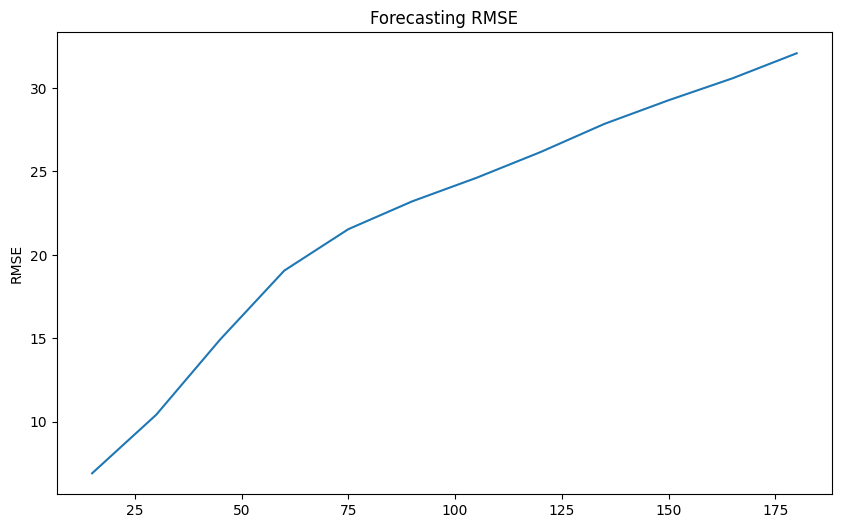

In [75]:
plt.figure(figsize=(10, 6))
plt.plot([x * 5 for x in forecast_sizes], total)
plt.ylabel("RMSE")
plt.title("Forecasting RMSE")
plt.show()